# A contracting cube

**Joakim Sundnes**

Date: **June 30, 2022**


## Model outline
This notebook introduces a slight extension of the simple unit cube model introduced previously. The model will still be a simple unit cube, fixed at one end ($x=0$) and loaded with a pressure load (negative pressure, i.e. stretch) at the other end ($x=1.0$). The following two extensions will be introduced:
* Replace the StVenant-Kirchhoff model with a model from Guccione et al (1995). 
* Add a time-varying active stress to the model

### The material model by Guccione et al

Soft biological tissues typically follow an exponential stress-strain relation. This relation was originally described by Fung, and has been implemented in a wide range of models for isotropic and anisotropic tissues. One of the most widely used material models for passive cardiac tissue is the model of Guccione et al from 1995. Several versions of the model have been used in the literature. We apply a transversely isotropic and nearly incompressible version, with strain energy given by:
$$
\begin{align*}
Q &= b_f E_{11}^2 + b_t (E_{22}^2 + E_{33}^2 + E_{23}^2 + E_{32}^2) + b_{fs}(E_{12}^2 + E_{21}^2 + E_{13}^2 + E_{31}^2),\\
\Psi &= \frac{C}{2}(e^Q-1)+ \kappa(J\ln(J)-J+1)  .
\end{align*}
$$
Here $E_{ij}$ are the components of the Green-Lagrange strain tensor, defined relative to the local fiber orientation. Furthermore $J$ is the determinant of the deformation gradient $F$ ($J=1$ for an incompressible material), and $C,B_f,b_t,b_{fs}, \kappa$ are material parameters. 

A Python class implementing the Guccione et al model can be found here:

* [Guccione model (1995)](./guccionematerial.py)

The class supports both fully incompressible and nearly incompressible models. The key part is the function named 'strain_energy', which defines the strain energy as a function of the deformation gradient $F$. When setting up the Fenics solver, you can use this predefined class or you can type the expression for the strain energy function directly in your solver code. 


### Setting up the Fenics solver
The bulk of the solver code will be identical to the first version of the unit cube. First, the usual imports, defining the mesh, the relevant function space and functions, and finally the Neumann and Dirichlet boundary conditions:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from fenics import *

# Optimization options for the form compiler
parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["representation"] = "uflacs"
parameters["form_compiler"]["quadrature_degree"] = 4


# Setup the mesh and the function space for the solutions
mesh = UnitCubeMesh(4,4,4)
V = VectorFunctionSpace(mesh, "Lagrange", 2)


# Define functions
v  = TestFunction(V)             # Test function
u  = Function(V)                 # Displacement from previous iteration

# Mark boundary subdomains
left =  CompiledSubDomain("near(x[0], side) && on_boundary", side = 0.0)
right = CompiledSubDomain("near(x[0], side) && on_boundary", side = 1.0)

boundary_markers = MeshFunction("size_t", mesh,mesh.topology().dim() - 1)
boundary_markers.set_all(0)
left.mark(boundary_markers, 1)
right.mark(boundary_markers, 2)

# Redefine boundary measure
ds = Measure('ds',domain=mesh,subdomain_data=boundary_markers)

# Define Dirichlet boundary (x = 0 or x = 1)
clamp = Constant((0.0, 0.0, 0.0))
bc = DirichletBC(V, clamp, left)
bcs = [bc]

Next, we turn to defining the mechanics problem. The following code defines the relevant kinematics, defines the stress tensor and the weak form, and finally solves the problem for a sequence of loads. However, the material definition is missing. Complete the code by introducing the Guccione material model, either by hardcoding the strain energy or importing and using the GuccioneMaterial class. 

No Jacobian form specified for nonlinear variational problem.Calling FFC just-in-time (JIT) compiler, this may take some time.

Differentiating residual form F to obtain Jacobian J = F'.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 0.000e+00 (tol = 1.000e-10) r (rel) = nan (tol = 1.000e-09)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.535e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 7.604e-01 (tol = 1.000e-10) r (rel) = 4.952e+00 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 4.608e-03 (tol = 1.000e-10) r (rel) = 3.001e-02 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 2.202e-04 (tol = 1.000e-10) r (rel) = 1.434e-03 (tol = 1.

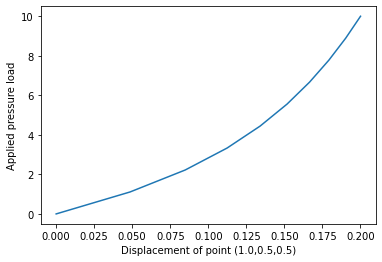

In [2]:
# Kinematics
d = len(u)
I = Identity(d)             # Identity tensor
F = I + grad(u)             # Deformation gradient
F = variable(F)

# Tissue microstructure
f0 = as_vector([ 1.0, 0.0, 0.0 ])
s0 = as_vector([ 0.0, 1.0, 0.0 ])
n0 = as_vector([ 0.0, 0.0, 1.0 ])
        
"""
Define the material model, either by defining the strain energy directly,
or using the guccione_material class (recommended). You can use the default 
material parameters. 
"""      
from guccionematerial import GuccioneMaterial      

mat = GuccioneMaterial(e1=f0,e2=s0,e3=n0,kappa=1e3,Tactive=0.0)
psi = mat.strain_energy(F)

P = diff(psi,F) # first Piola-Kirchhoff stress tensor

p_right = Constant(0.0) #the pressure load (zero for now)

# Definition of the weak form:
N = FacetNormal(mesh)
Gext = p_right * inner(v, det(F)*inv(F)*N) * ds(2) #ds(2) = left boundary
R = inner(P,grad(v))*dx + Gext 

#N = FacetNormal(mesh)
#Gext = p_right * inner(v, det(F)*inv(F)*N) * ds(2) #ds(2) = left boundary
#R = inner(P,grad(v))*dx + Gext 

# Step-wise loading (for plotting and convergence)
load_steps = 10
target_load = 10.0

# The middle point on the right boundary
point0 = np.array([1.0,0.5,0.5])

d0 = np.zeros(3)                #displacement at point0
disp = np.zeros(load_steps) #array to store displacement for all steps

# Define and loop over load steps:
loads = np.linspace(0,target_load,load_steps)

disp_file = XDMFFile("displacement/u.xdmf")

for step in range(load_steps):
    # A stretch is a negative pressure
    p_right.assign(-loads[step])
    
    #solve the problem:
    solve(R == 0, u, bcs)
    
    #evaluate displacement at point defined above
    u.eval(d0,point0)
    disp[step] = d0[0]
    disp_file.write_checkpoint(u, "Displacement", step, append=True)

disp_file.close()

       
#displacement on x-axis, load on y-axis
plt.figure(1)
plt.plot(disp,loads)
plt.xlabel('Displacement of point (1.0,0.5,0.5)')
plt.ylabel('Applied pressure load')

plt.show()

### Adding active contraction

Finally, we want to add active contraction to the tissue cube. If we want to simulate a full cardiac cycle, a simple option would be to assign an active stress transient similar to the one output from the Rice et al model:

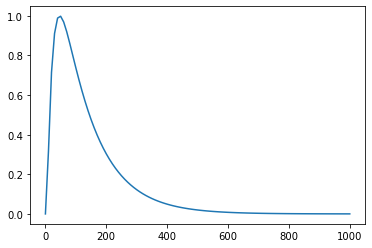

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import math

force_amplitude=1.0
#Ca_diastolic=0.09
start_time=5, 
tau1=20 
tau2=110
t = np.linspace(0,1000,101)

beta = -math.pow(tau1/tau2, -1/(1 - tau2/tau1)) + math.pow(tau1/tau2,\
        -1/(-1 + tau1/tau2))
force = ((force_amplitude)*(np.exp((start_time - t)/tau1) -\
        np.exp((start_time - t)/tau2))/beta) 

#the following line implements the if test in numpy without a loop
force = force*(t>=start_time)+ 0.0*(t<start_time)

plt.plot(t,force)
plt.show()

For now, we will keep things even simpler, and simply model the first phase of contraction by adding a linearly increasing active stress. For this case we consider an unloaded cube ($p=0$ on the right boundary). If you used the 'GuccioneModel' class above to define the passive material properties, the active stress may be set in the function 'set_active_stress'. The following code, mostly copied from above, includes an incomplete problem definiton. The missing piece is the incoroporation of the active stress. Complete the code to make it run:

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 0.000e+00 (tol = 1.000e-10) r (rel) = nan (tol = 1.000e-09)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.295e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 6.113e-01 (tol = 1.000e-10) r (rel) = 4.719e+00 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 2.231e-03 (tol = 1.000e-10) r (rel) = 1.722e-02 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 7.638e-04 (tol = 1.000e-10) r (rel) = 5.896e-03 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 4.627e-09 (tol = 1.000e-10) r (rel) = 3.572e-08 (tol = 1.000e-09)
  Newton iteration 5: r (

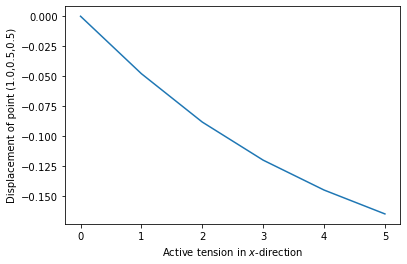

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from fenics import *

from guccionematerial import GuccioneMaterial

# Optimization options for the form compiler
parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["representation"] = "uflacs"
parameters["form_compiler"]["quadrature_degree"] = 4


# Setup the mesh and the function space for the solutions
mesh = UnitCubeMesh(4,4,4)
V = VectorFunctionSpace(mesh, "Lagrange", 2)

# Define functions
v  = TestFunction(V)             # Test function
u  = Function(V)                 # Displacement from previous iteration

# Mark boundary subdomains
left =  CompiledSubDomain("near(x[0], side) && on_boundary", side = 0.0)
right = CompiledSubDomain("near(x[0], side) && on_boundary", side = 1.0)

boundary_markers = MeshFunction("size_t", mesh,mesh.topology().dim() - 1)
boundary_markers.set_all(0)
left.mark(boundary_markers, 1)
right.mark(boundary_markers, 2)

# Redefine boundary measure
ds = Measure('ds',domain=mesh,subdomain_data=boundary_markers)

# Define Dirichlet boundary (x = 0 or x = 1)
clamp = Constant((0.0, 0.0, 0.0))
bc = DirichletBC(V, clamp, left)
bcs = [bc]

# Kinematics
d = len(u)
I = Identity(d)             # Identity tensor
F = I + grad(u)             # Deformation gradient
#C = F.T*F                   # the right Cauchy-Green tensor
#E = 0.5*(C - I)             # the Green-Lagrange strain tensor

F = variable(F)

# Tissue microstructure
f0 = as_vector([ 1.0, 0.0, 0.0 ])
s0 = as_vector([ 0.0, 1.0, 0.0 ])
n0 = as_vector([ 0.0, 0.0, 1.0 ])

mat = GuccioneMaterial(e1=f0,e2=s0,e3=n0,kappa=1e3,Tactive=0.0)
psi = mat.strain_energy(F)

P = diff(psi,F) # first Piola-Kirchhoff stress tensor

p_right = Constant(0.0) #the pressure load (zero for now)

# Definition of the weak form:
N = FacetNormal(mesh)
Gext = p_right * inner(v, det(F)*inv(F)*N) * ds(2) #ds(2) = left boundary
R = inner(P,grad(v))*dx + Gext

# The middle point on the right boundary
point0 = np.array([1.0,0.5,0.5])

# Step-wise loading (for plotting and convergence)
active_steps = 6
target_active = 5.0
active = np.linspace(0,target_active,active_steps)

d0 = np.zeros(3)                #displacement at point0
disp = np.zeros(active_steps)     #array to store displacement for all steps

for step in range(active_steps):
    mat.set_active_stress(active[step])
    solve(R == 0, u, bcs)
    
    #evaluate displacement at point defined above
    u.eval(d0,point0)
    disp[step] = d0[0]

    
#displacement on x-axis, load on y-axis
plt.figure(1)
plt.plot(active,disp)
plt.xlabel('Active tension in $x$-direction')
plt.ylabel('Displacement of point (1.0,0.5,0.5)')

plt.show()
